In [19]:
from Transformer import *
from RNN import *
from train_utils import *

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load the entire dataset
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# For subject 1
subject1_indices_train = np.where(person_train_valid == 0)[0]
subject1_indices_test = np.where(person_test == 0)[0]
X_train_valid1 = X_train_valid[subject1_indices_train]
y_train_valid1 = y_train_valid[subject1_indices_train]
X_test1 = X_test[subject1_indices_test]
y_test1 = y_test[subject1_indices_test]

# For all subject
dataset, X_val, y_val, X_test, y_test = process_data(X_train_valid, 
                                                     y_train_valid, 
                                                     X_test, 
                                                     y_test)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True)

# For subject 1
dataset1, X_val1, y_val1, X_test1, y_test1 = process_data(X_train_valid1, 
                                                          y_train_valid1,
                                                          X_test1, 
                                                          y_test1)
dataloader1 = DataLoader(dataset1, batch_size=100, shuffle=True, drop_last=True)

#### Initial training and testing on RNN/LSTM without attention

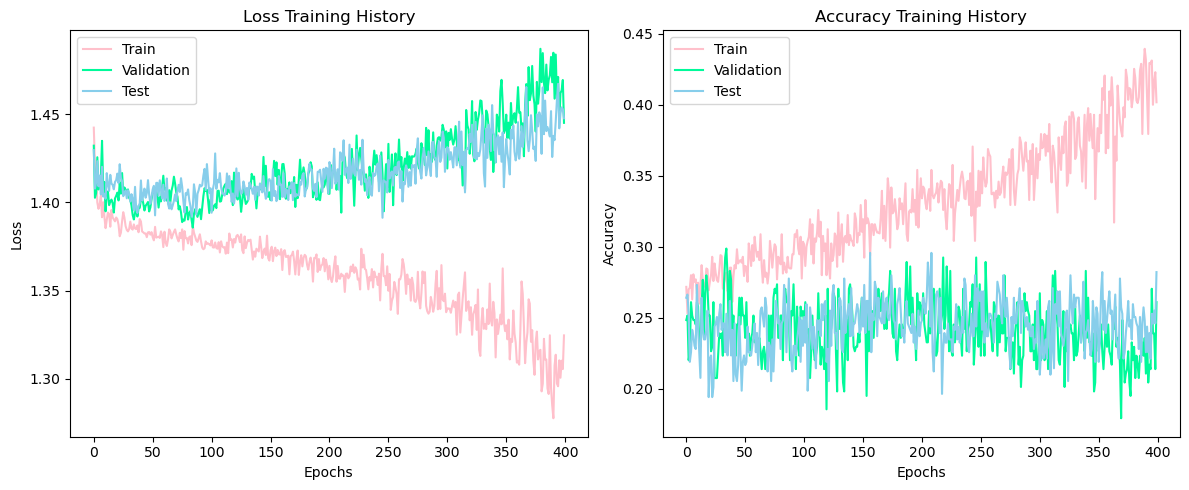

Best test accuracy for RNN on all subjects, all epochs, is  0.29571106094808125


In [2]:
rnn_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':False,
            'use_attention':False}
rnn = RNN(rnn_config)
rnn_optimizer = optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(400, 
                                                                            rnn, 
                                                                            rnn_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            700, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for RNN on all subjects, all epochs, is ", max(test_acc))

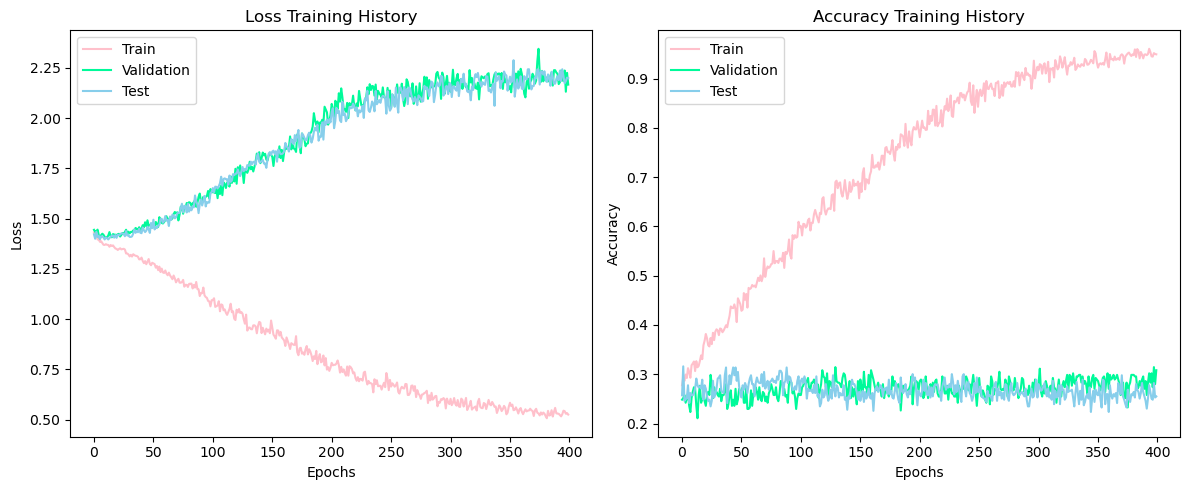

Best test accuracy for LSTM  on all subjects, all epochs, is  0.3160270880361174


In [3]:
lstm_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':True,
            'use_attention':False}
lstm = RNN(lstm_config)
lstm_optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(400, 
                                                                            lstm, 
                                                                            lstm_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            700, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for LSTM  on all subjects, all epochs, is ", max(test_acc))

#### Optimize the classification accuracy for subject 1. Does it help to train across all subjects?

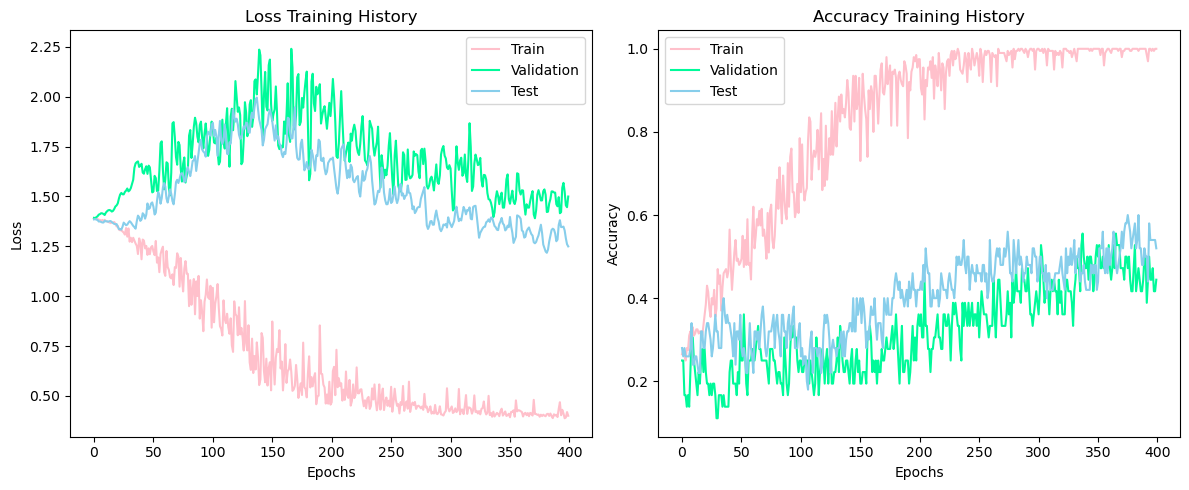

Best test accuracy on subject 1 for RNN, all epochs, is  0.6
Test accuracy for the model with the highest validation accuracy for the same subject is  0.48
Test accuracy for the model with the highest validation accuracy for all subjects is  0.3160270880361174


In [4]:
rnn_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':False,
            'use_attention':True}
rnn = RNN(rnn_config)
rnn_optimizer = optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(400, 
                                                                            rnn, 
                                                                            rnn_optimizer, 
                                                                            dataloader1, 
                                                                            X_val1, y_val1, 
                                                                            X_test1, y_test1, 
                                                                            700, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy on subject 1 for RNN, all epochs, is ", max(test_acc))
print("Test accuracy for the model with the highest validation accuracy for the same subject is ", 
      evaluate(best_model, X_test1, y_test1, 700))
print("Test accuracy for the model with the highest validation accuracy for all subjects is ", 
      evaluate(best_model, X_test, y_test, 700))

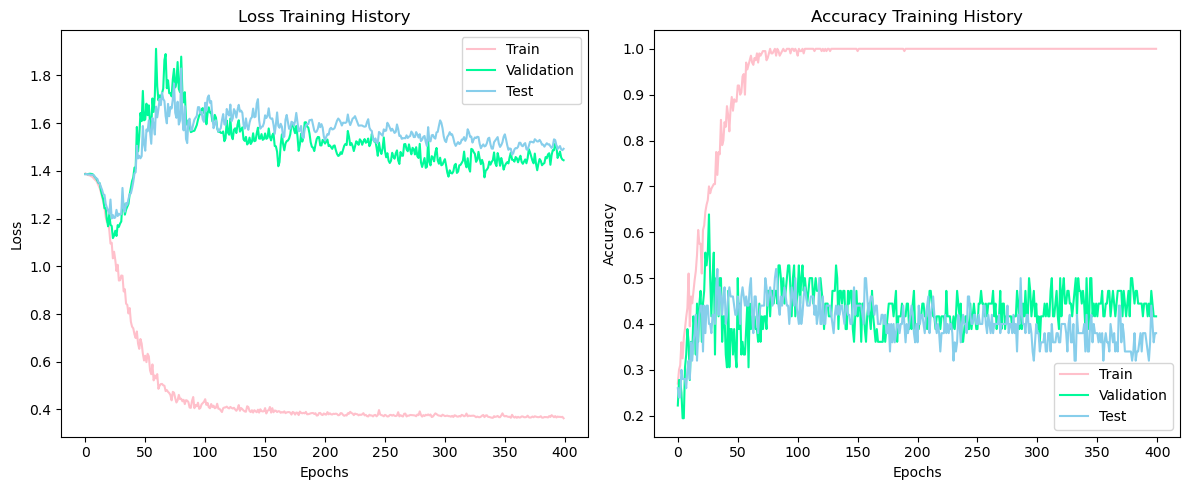

Best test accuracy  on subject 1 for LSTM, all epochs, is  0.52
Test accuracy for the model with the highest validation accuracy for the same subject is  0.4
Test accuracy for the model with the highest validation accuracy for all subjects is  0.3431151241534989


In [5]:
lstm_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':True,
            'use_attention':True}
lstm = RNN(lstm_config)
lstm_optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(400, 
                                                                            lstm, 
                                                                            lstm_optimizer, 
                                                                            dataloader1, 
                                                                            X_val1, y_val1, 
                                                                            X_test1, y_test1, 
                                                                            700, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy  on subject 1 for LSTM, all epochs, is ", max(test_acc))
print("Test accuracy for the model with the highest validation accuracy for the same subject is ", 
      evaluate(best_model, X_test1, y_test1, 700))
print("Test accuracy for the model with the highest validation accuracy for all subjects is ", 
      evaluate(best_model, X_test, y_test, 700))

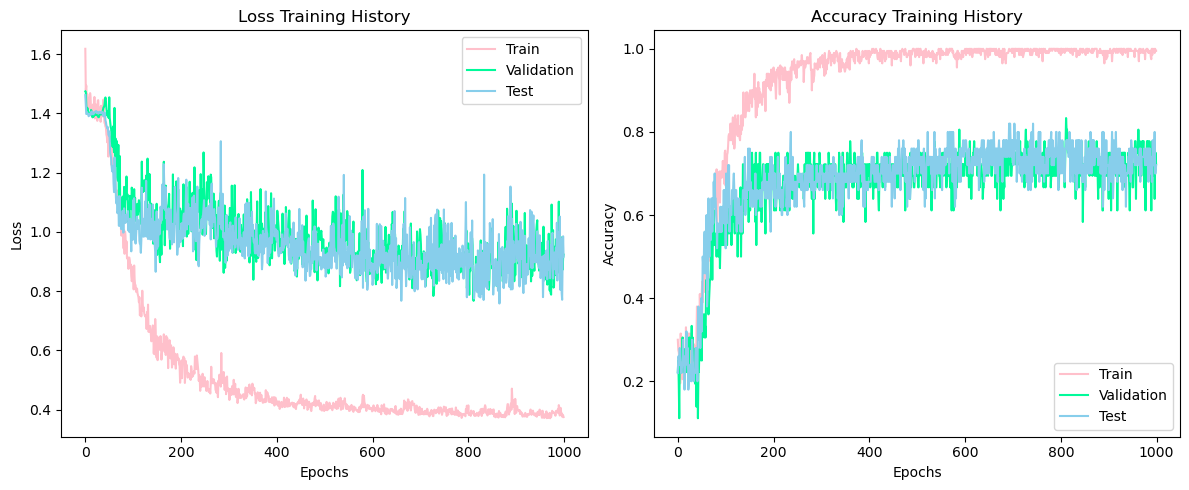

Best test accuracy for Transformer  on subject 1, all epochs, is  0.82
Test accuracy for the model with the highest validation accuracy for the same subject is  0.76
Test accuracy for the model with the highest validation accuracy for all subjects is  0.39503386004514673


In [15]:
t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
transformer = Transformer(t_config)
transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(1000, 
                                                                            transformer, 
                                                                            transformer_optimizer, 
                                                                            dataloader1, 
                                                                            X_val1, y_val1, 
                                                                            X_test1, y_test1, 
                                                                            700, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for Transformer  on subject 1, all epochs, is ", max(test_acc))
print("Test accuracy for the model with the highest validation accuracy for the same subject is ", 
      evaluate(best_model, X_test1, y_test1, 700))
print("Test accuracy for the model with the highest validation accuracy for all subjects is ", 
      evaluate(best_model, X_test, y_test, 700))

#### Optimize the classification accuracy across all subjects. How does the classifier do? Do you notice any interesting trends?

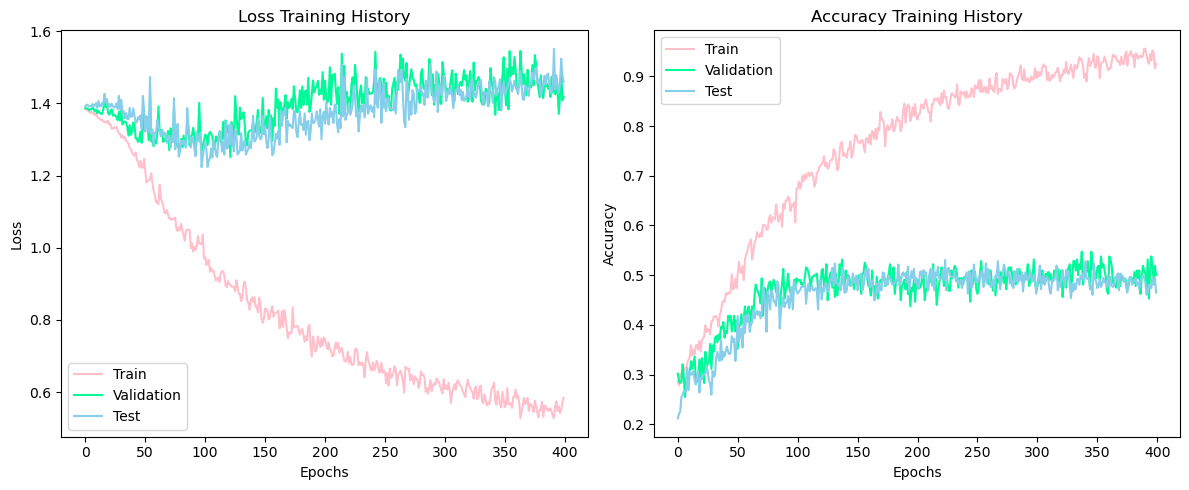

Best test accuracy for RNN on all subjects, all epochs, is  0.5304740406320542
Test accuracy for the model with the highest validation accuracy for the subject1 is  0.38
Test accuracy for the model with the highest validation accuracy for all subjects is  0.4785553047404063


In [7]:
rnn_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':False,
            'use_attention':True}
rnn = RNN(rnn_config)
rnn_optimizer = optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(400, 
                                                                            rnn, 
                                                                            rnn_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            700, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for RNN on all subjects, all epochs, is ", max(test_acc))
print("Test accuracy for the model with the highest validation accuracy for the subject1 is ", 
      evaluate(best_model, X_test1, y_test1, 700))
print("Test accuracy for the model with the highest validation accuracy for all subjects is ", 
      evaluate(best_model, X_test, y_test, 700))

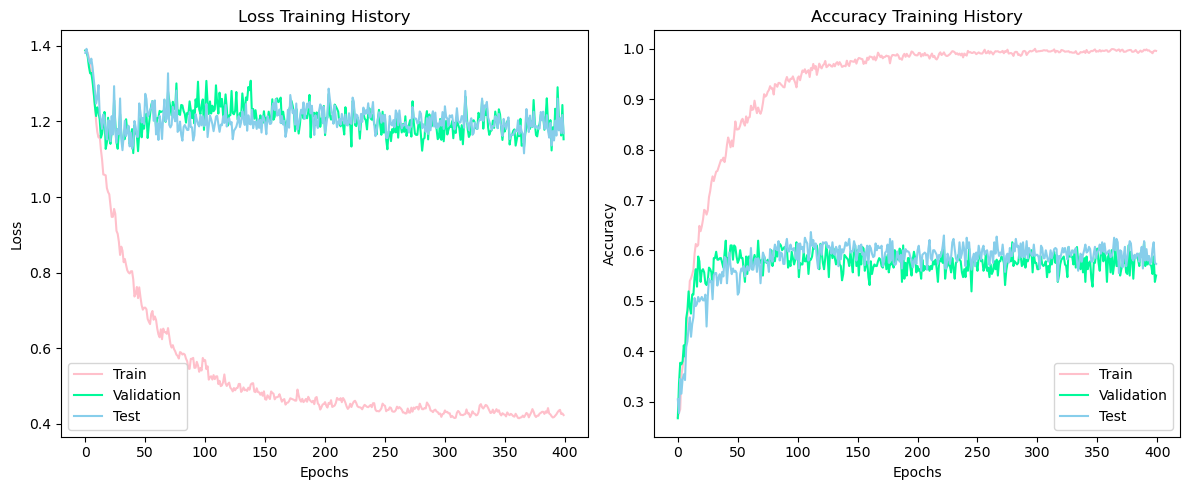

Best test accuracy for LSTM  on all subjects, all epochs, is  0.636568848758465
Test accuracy for the model with the highest validation accuracy for the subject1 is  0.52
Test accuracy for the model with the highest validation accuracy for all subjects is  0.5846501128668171


In [8]:
lstm_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':True,
            'use_attention':True}
lstm = RNN(lstm_config)
lstm_optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(400, 
                                                                            lstm, 
                                                                            lstm_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            700, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for LSTM  on all subjects, all epochs, is ", max(test_acc))
print("Test accuracy for the model with the highest validation accuracy for the subject1 is ", 
      evaluate(best_model, X_test1, y_test1, 700))
print("Test accuracy for the model with the highest validation accuracy for all subjects is ", 
      evaluate(best_model, X_test, y_test, 700))

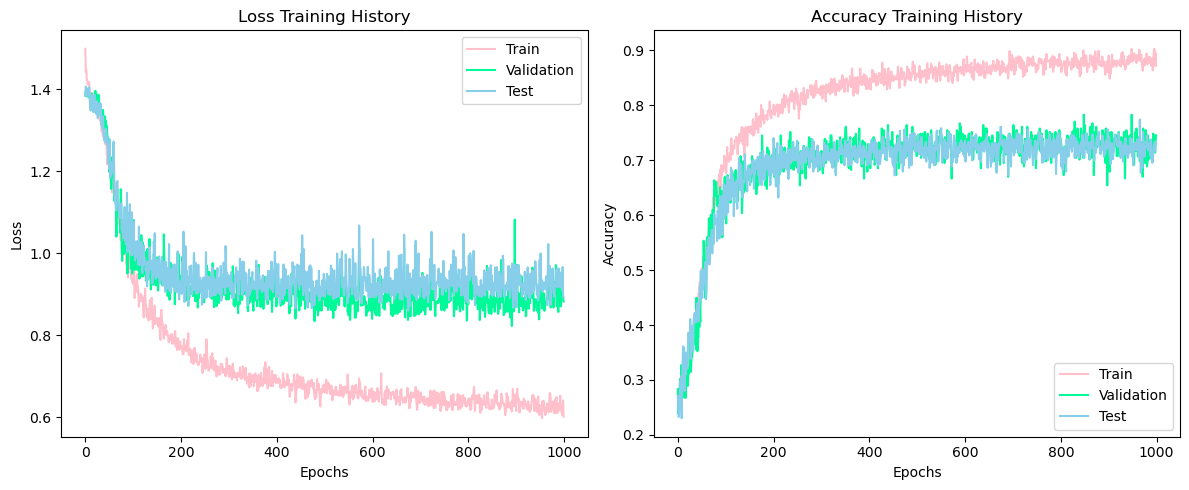

Best test accuracy for Transformer on all subjects, all epochs, is  0.7742663656884876
Test accuracy for the model with the highest validation accuracy for the subject1 is  0.7
Test accuracy for the model with the highest validation accuracy for all subjects is  0.7381489841986456


In [20]:
t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
transformer = Transformer(t_config)
transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(1000, 
                                                                            transformer, 
                                                                            transformer_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            700, mute=True, save=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for Transformer on all subjects, all epochs, is ", max(test_acc))
print("Test accuracy for the model with the highest validation accuracy for the subject1 is ", 
      evaluate(best_model, X_test1, y_test1, 700))
print("Test accuracy for the model with the highest validation accuracy for all subjects is ", 
      evaluate(best_model, X_test, y_test, 700))

#### Evaluate the classification accuracy as a function of time (e.g., does it increase as you have data over longer periods of time? how much time is required to get a reasonable classification accuracy?)

In [21]:
seq_len = [100, 200, 300, 400, 500, 600, 700, 800, 900]
acc_history = []
loss_history = []
for l in seq_len:
    t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
    transformer = Transformer(t_config)
    transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
    train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(1000, 
                                                                                transformer, 
                                                                                transformer_optimizer, 
                                                                                dataloader, 
                                                                                X_val, y_val, 
                                                                                X_test, y_test, 
                                                                                l, mute=True)
    acc_history.append(test_acc)
    loss_history.append(test_loss)

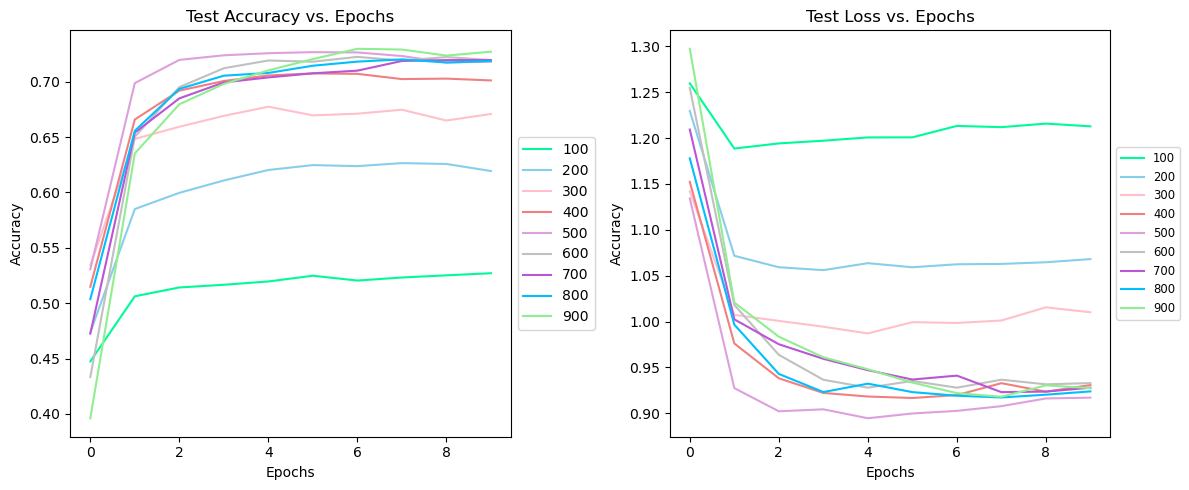

In [22]:
colors = ['mediumspringgreen', 'skyblue', 'pink', 
          'lightcoral', 'plum', 'silver', 
          'mediumorchid', 'deepskyblue', 'lightgreen']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(len(seq_len)):
    acc = np.array(acc_history[i])
    acc = acc.reshape(-1, 100)
    acc = np.mean(acc, axis=1)
    axes[0].plot(acc, label=seq_len[i], color=colors[i])
    
    l = np.array(loss_history[i])
    l = l.reshape(-1, 100)
    l = np.mean(l, axis=1)
    axes[1].plot(l, label=seq_len[i], color=colors[i])
    
axes[0].set_title("Test Accuracy vs. Epochs")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1].set_title("Test Loss vs. Epochs")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()

In [23]:
seq_len = [50, 60, 70, 80, 90]
acc_history = []
loss_history = []
for l in seq_len:
    t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
    transformer = Transformer(t_config)
    transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
    train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_model = model_train(500, 
                                                                                transformer, 
                                                                                transformer_optimizer, 
                                                                                dataloader, 
                                                                                X_val, y_val, 
                                                                                X_test, y_test, 
                                                                                l, mute=True)
    acc_history.append(test_acc)
    loss_history.append(test_loss)

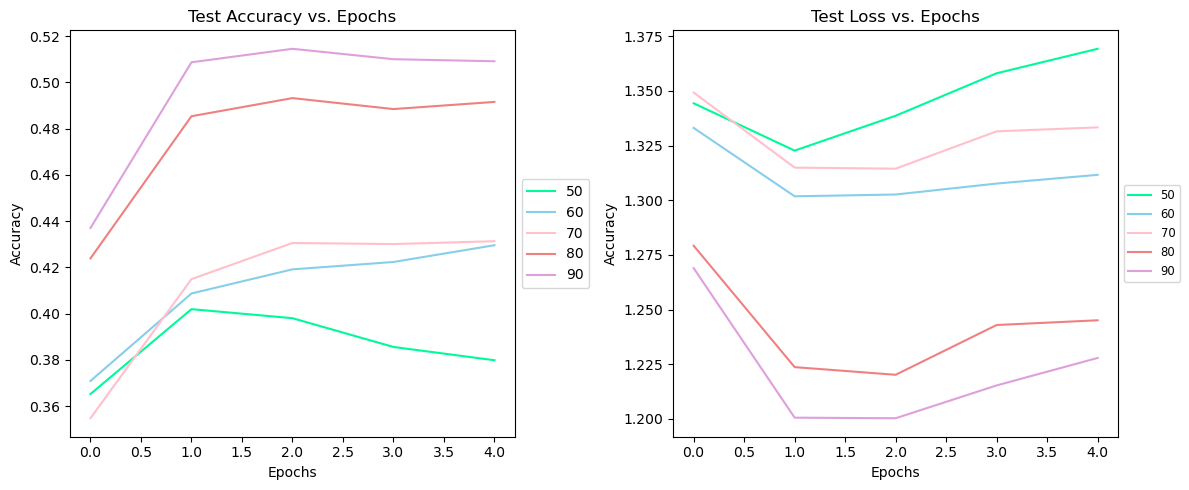

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(len(seq_len)):
    acc = np.array(acc_history[i])
    acc = acc.reshape(-1, 100)
    acc = np.mean(acc, axis=1)
    axes[0].plot(acc, label=seq_len[i], color=colors[i])
    
    l = np.array(loss_history[i])
    l = l.reshape(-1, 100)
    l = np.mean(l, axis=1)
    axes[1].plot(l, label=seq_len[i], color=colors[i])
    
axes[0].set_title("Test Accuracy vs. Epochs")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1].set_title("Test Loss vs. Epochs")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()

#### Does the model perform the same when given X_test with different lengths?

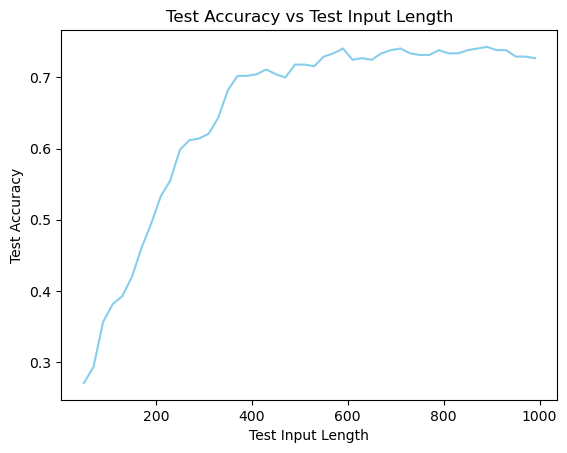

In [25]:
best_model = torch.load("best_model.pth")
accuracy = []
seq_len = []
for l in np.arange(50, 1000, 20):
    accuracy.append(evaluate(best_model, X_test, y_test, l))
    seq_len.append(l)
plt.plot(seq_len, accuracy, colors[1])
plt.title("Test Accuracy vs Test Input Length")
plt.xlabel("Test Input Length")
plt.ylabel("Test Accuracy")
plt.show()
    